# <center>Симуляция распространения болезни</center>

### Content

* [Подготовка к работе](#preload)
* [EDA](#eda)
* [Часть 1. Пишем симуляцию.](#part_1)
* [Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?](#part_2)
* [Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?](#part_3)

## <center>Подготовка к работе <a class="anchor" id="preload"/></center>

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import kagglehub

from tqdm import tqdm
from scipy.stats import spearmanr
from datetime import datetime, timedelta
from typing import NamedTuple
from statistics import median
from lib import utils

import warnings

warnings.filterwarnings("ignore")

In [3]:
dataset_dir = project_dir + '/datasets/vikalpdongre/us-flights-data-2008'

In [4]:
# # Копирование данных из Kaggle в локальный каталог. Делается один раз
# import shutil

# path = kagglehub.dataset_download("vikalpdongre/us-flights-data-2008")
# # print("Path to dataset files:", path)

# shutil.rmtree(dataset_dir, True)
# shutil.copytree(path, dataset_dir)
# shutil.rmtree(path)

In [5]:
df_src = pd.read_csv(dataset_dir + "/2008.csv", delimiter=",")

df = df_src.copy()

## <center>EDA <a class="anchor" id="eda"/></center>

Сперва удалим ненужные признаки и несовершенные рейсы. 
Рейсы, которые были перенаправлены в другие аэропорты тоже удалим, так как по ним нет данных о времени прилета.

In [6]:
df = df[df['Cancelled'] == 0]
df = df[df['ArrTime'].notna()]

df = df[['Year', 'Month', 'DayofMonth', 'DepTime', 'ArrTime', 'Origin', 'Dest', 'Distance']] 

In [7]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Year,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008
Month,1,1,1,1,1,1,1,1,1,1
DayofMonth,3,3,3,3,3,3,3,3,3,3
DepTime,2003.0,754.0,628.0,926.0,1829.0,1940.0,1937.0,1039.0,617.0,1620.0
ArrTime,2211.0,1002.0,804.0,1054.0,1959.0,2121.0,2037.0,1132.0,652.0,1639.0
Origin,IAD,IAD,IND,IND,IND,IND,IND,IND,IND,IND
Dest,TPA,TPA,BWI,BWI,BWI,JAX,LAS,LAS,MCI,MCI
Distance,810,810,515,515,515,688,1591,1591,451,451


In [8]:
print('Dataframe dimensions:', df.shape)

i1 = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
i2 = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})
i3 = pd.DataFrame(df.isnull().sum() / df.shape[0]*100).T.rename(index={0:'null values (%)'})
i4 = pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

pd.concat([i1, i2, i3]).T

Dataframe dimensions: (6858079, 8)


,column type,null values (nb),null values (%)
Year,int64,0,0.0
Month,int64,0,0.0
DayofMonth,int64,0,0.0
DepTime,float64,0,0.0
ArrTime,float64,0,0.0
Origin,object,0,0.0
Dest,object,0,0.0
Distance,int64,0,0.0


#### Разбор TimeZone

In [9]:
df_tz = pd.read_csv(project_dir + "/hw-04/iata.tzmap", delimiter="\\t", header=None, names=['IATA_CODE', 'TimeZone'])

In [10]:
_df1 = pd.merge(df, df_tz, left_on='Origin', right_on = 'IATA_CODE', how='inner')
_df1.drop(columns=['IATA_CODE'], inplace=True)
_df1.rename(columns={'TimeZone': 'Origin_TZ'}, inplace=True)

_df1 = pd.merge(_df1, df_tz, left_on='Dest', right_on = 'IATA_CODE', how='inner')
_df1.drop(columns=['IATA_CODE'], inplace=True)
_df1.rename(columns={'TimeZone': 'Dest_TZ'}, inplace=True)

_df1['DepTime_H'] = _df1['DepTime'].map(lambda x: int(x // 100))
_df1['DepTime_m'] = _df1['DepTime'].map(lambda x: int(x % 100))

_df1['ArrTime_H'] = _df1['ArrTime'].map(lambda x: int(x // 100))
_df1['ArrTime_m'] = _df1['ArrTime'].map(lambda x: int(x % 100))

Вычисление времени в минутах от Unix TimeStamp с учетом TimeZone аэропортов

In [11]:
_df1['DepTime_dt'] = pd.to_datetime({
    'year': _df1['Year'],
    'month': _df1['Month'],
    'day': _df1['DayofMonth'],
    'hour': _df1['DepTime_H'],
    'minute': _df1['DepTime_m']
})

_df1['ArrTime_dt'] = pd.to_datetime({
    'year': _df1['Year'],
    'month': _df1['Month'],
    'day': _df1['DayofMonth'],
    'hour': _df1['ArrTime_H'],
    'minute': _df1['ArrTime_m']
})

_df1['DepTime_dt'] = list(map(
    lambda ts, tz: ts.tz_localize(
        tz,
        ambiguous=True,
        nonexistent='shift_forward'
    ),
    _df1['DepTime_dt'],
    _df1['Origin_TZ']
))

_df1['ArrTime_dt'] = list(map(
    lambda ts, tz: ts.tz_localize(
        tz,
        ambiguous=False,
        nonexistent='shift_forward'
    ),
    _df1['ArrTime_dt'],
    _df1['Dest_TZ']
))

In [12]:
# исправление случая, когда время прилета попадает на следующие сутки
_df1['ArrTime_dt'] = np.where(_df1['DepTime_dt'] > _df1['ArrTime_dt'], _df1['ArrTime_dt'] + timedelta(days=1), _df1['ArrTime_dt'])
# исправление случая, когда прилет попадает на переход на зимнее время
_df1['ArrTime_dt'] = np.where(_df1['DepTime_dt'] >= _df1['ArrTime_dt'], _df1['ArrTime_dt'] + timedelta(hours=1), _df1['ArrTime_dt'])

In [13]:
df_dt = _df1[['Origin', 'Dest', 'Distance', 'DepTime_dt', 'ArrTime_dt']]

In [14]:
# полный отсортированный список уникальных аэропортов
all_airports = sorted(pd.concat([df_dt['Origin'], df_dt['Dest']]).unique())

## <center>Часть 1. Пишем симуляцию.<a class="anchor" id="part_1"/></center>

In [15]:
# отсортированный dataset по дате вылета 
df_sorted_dep = df_dt.sort_values(by='DepTime_dt')

In [16]:
# Даты начала и конца симуляции
simulation_start_date = df_sorted_dep[['DepTime_dt', 'ArrTime_dt']].min().min()
simulation_end_date = df_sorted_dep[['DepTime_dt', 'ArrTime_dt']].max().max()

Функция для симуляции одного прохода по всему датасету и распространения инфекции.

In [17]:
# Создаём свой класс для row
class FlightRow(NamedTuple):
    Index: int
    Origin: str
    Dest: str
    Distance: int
    DepTime_dt: datetime
    ArrTime_dt: datetime

def process(iata_start: str|None, p: float)->dict:
    # словарь аэропортов с признаком времени заражения
    infected_airports = {}
    for i in all_airports:
        infected_airports[i] = None

    _is_taint = False # флаг начала заражения

    for row in df_sorted_dep.itertuples(index=True, name='FlightRow'):
        # Пропускаем все вылеты из незараженных аэропортов
        if not _is_taint:
            if iata_start is not None and row.Origin != iata_start:
                continue
            _is_taint = True
            # Отмечаем с этого момента зараженным аэропорт
            orig_date_ts = int(row.DepTime_dt.timestamp())
            infected_airports[row.Origin] = orig_date_ts
        
        # По времени прилета определяем с какого момента будет заражен другой аэропорт
        dest_date_ts = int(row.ArrTime_dt.timestamp())

        if np.random.uniform() < p: # если случилось заражение
            if infected_airports[row.Dest] is None:
                infected_airports[row.Dest] = dest_date_ts
            else:
                infected_airports[row.Dest] = min(dest_date_ts, infected_airports[row.Dest])

    return infected_airports

## <center>Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?<a class="anchor" id="part_2"/></center>

In [18]:
P_STEPS = [0.01, 0.05, 0.1, 0.5, 1.]
CYCLES = 10

STAT = {}

for p in tqdm(P_STEPS):
    STAT[p] = []
    for c in range(0, CYCLES):
        STAT[p].append(process(None, p))
        if p == 1.:
            # одного прохода будет достаточно, т.к. они все будут одинаковые
            break

100%|██████████| 5/5 [17:14<00:00, 206.92s/it]


In [19]:
# Метод возвращает упорядоченные метки времени, когда произошло заражение
# и количество зараженных в это время объектов

def infected_count_by_date(infected_airports):
    # незараженные аэропорты
    clear_airports = []

    count_dict = {}
    for airport, timestamp in infected_airports.items():
        if timestamp is None:
            clear_airports.append(airport)
            continue
        count_dict[timestamp] = count_dict.get(timestamp, 0) + 1
    # в порядке даты заражения количество аэропортов
    return dict(sorted(count_dict.items()))

In [20]:
TOTAL_AIRPORTS = len(all_airports)

# Метод формирует хронлогическую последовательность по равным интервалам 
# с общей долей зараженных аэропортов в данные интервалы

def stat_slices(infected_airports, hours=12):
    infection_history = infected_count_by_date(infected_airports)
    _stat = []
    _counter = 0
    _current = simulation_start_date
    while _current < simulation_end_date:
        _next = _current + pd.Timedelta(hours=hours)
        _current_ts = int(_current.timestamp())
        _next_ts    = int(_next.timestamp())
        for _ts, _cnt in infection_history.items():
            if _ts >= _current_ts and _ts < _next_ts:
                _counter += _cnt
        _stat.append(_counter / TOTAL_AIRPORTS)
        _current = _next

    return _stat

In [21]:
MEANS = {}

for p, stat_set in tqdm(STAT.items()):
    _stat = []
    for experiment in stat_set:
        # print(experiment)
        _stat.append(stat_slices(experiment))
    arr = np.array(_stat)
    # Среднее по столбцам (axis=0)
    MEANS[p] = np.mean(arr, axis=0)

100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


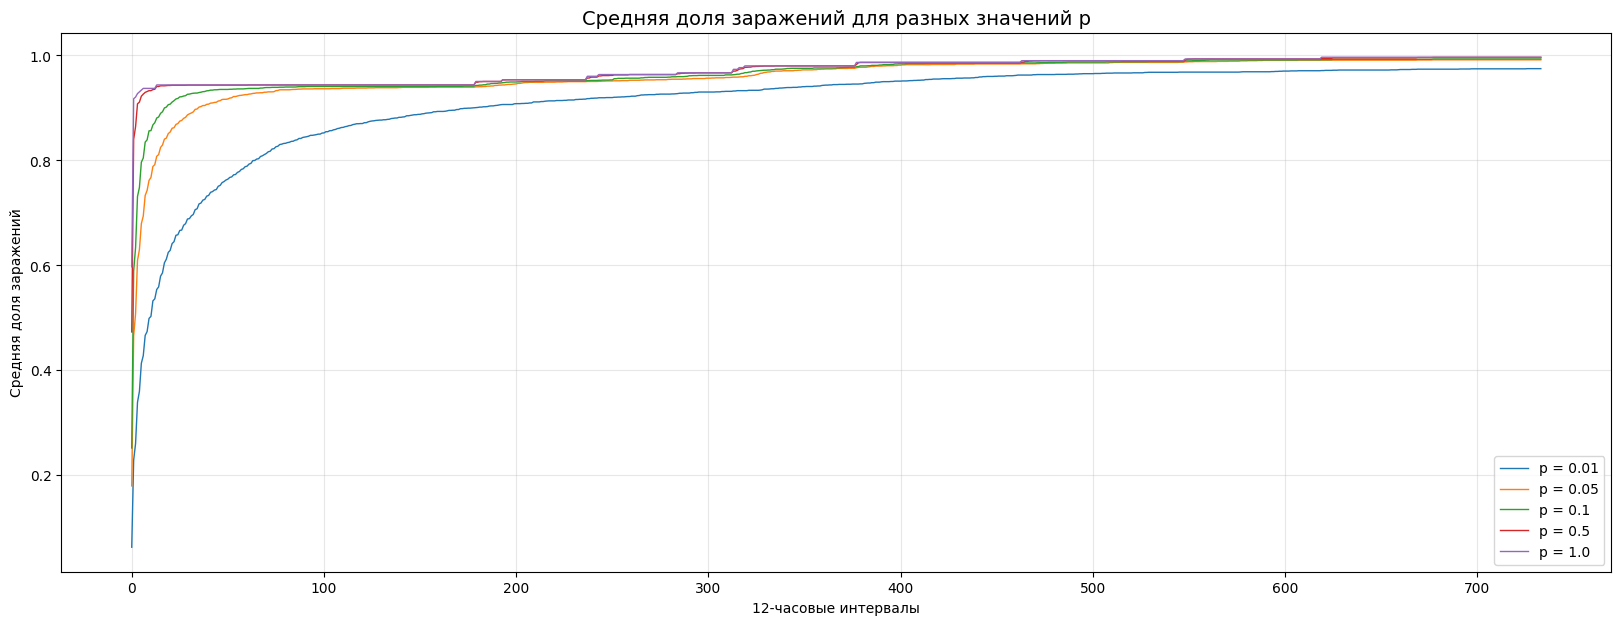

In [22]:
plt.figure(figsize=(20, 7))

for p, m in MEANS.items():
    x = np.arange(len(m))
    y = np.array(m)
    plt.plot(x, y, '-', markersize=1, label=f'p = {p}', linewidth=1)

plt.title('Средняя доля заражений для разных значений p', fontsize=14)
plt.xlabel('12-часовые интервалы')
plt.ylabel('Средняя доля заражений')
plt.legend()
plt.grid(alpha=0.3)
plt.show()    

## <center>Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?<a class="anchor" id="part_3"/></center>

Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное
число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, 
из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.

In [23]:
TOTAL_FLIGHTS = len(df)

In [24]:
# Формирование кортежа-ключа для будущего ненаправленного графа
def _gr(origin, dest):
    return (min(origin, dest), max(origin, dest))

flights_pairs = df[['Origin', 'Dest']]
flights_pairs['key'] = flights_pairs.apply(lambda x: _gr(x['Origin'], x['Dest']), axis=1)

In [25]:
# Подсчет количества рейсов между аэропортами в оба направления
flights_count = flights_pairs.groupby(['key']).size().reset_index(name='count')
flights_count

,key,count
0,"(ABE, ATL)",1679
1,"(ABE, BHM)",1
2,"(ABE, CLE)",1583
3,"(ABE, CLT)",918
4,"(ABE, CVG)",490
...,...,...
2678,"(SRQ, TPA)",2
2679,"(STL, TPA)",2161
2680,"(STL, TUL)",1782
2681,"(SWF, TPA)",464


In [26]:
# Создание графа
G = nx.Graph()

# Добавление рёбер с относительными весами
for _, row in flights_count.iterrows():
    (u, v) = tuple(row['key'])
    weight = int(row['count']) / TOTAL_FLIGHTS
    G.add_edge(u, v, weight=weight)

print("Число узлов:", G.number_of_nodes())
print("Число рёбер:", G.number_of_edges())

Число узлов: 303
Число рёбер: 2683


In [27]:
# метод вычисления медианного значения по списку экспериментов

def median_by_key(stat: list, start_ts: int):
    # Собираем значения по ключам
    _buckets = {}
    for _experiment in stat:
        for _city, _ts in _experiment.items():
            if _ts is None:
                continue
            ts_from = _ts - start_ts
            _buckets.setdefault(_city, []).append(ts_from)

    # Считаем медиану по каждому ключу
    return {k: median(v) for k, v in _buckets.items()}

In [28]:
# Метод вычисления времени заражения каждого аэропорта
# Вес ребра - это по сути вероятность заражения аэропорта от одного рейса, при условии, 
# что один из аэропортов был уже заражен

MEDIAN_STAT = []
for i in range(0, 50):
    MEDIAN_STAT.append(process('ABE', 0.5))

In [29]:
median_result = median_by_key(MEDIAN_STAT, int(simulation_start_date.timestamp()))

In [30]:
# Коэффициент кластеризации для каждой вершины
clustering = nx.clustering(G)
# Степень вершин (возвращает dict: {node: degree})
degree = dict(G.degree())
# Посредническая центральность (betweenness centrality)
betweenness = nx.betweenness_centrality(G)

In [31]:
df_res = pd.DataFrame({
    'airport':     list(median_result.keys()),
    'median_time': [median_result[city] for city in median_result],
    'clustering':  [clustering[city] for city in median_result],
    'degree':      [degree[city] for city in median_result],
    'betweenness': [betweenness[city] for city in median_result]
})
df_res

,airport,median_time,clustering,degree,betweenness
0,ABE,21720.0,0.836364,11,1.138515e-04
1,ABI,48840.0,0.000000,1,0.000000e+00
2,ABQ,34140.0,0.648718,40,3.001022e-03
3,ABY,49920.0,0.000000,1,0.000000e+00
4,ACK,12308280.0,0.666667,3,3.548664e-07
...,...,...,...,...,...
297,WYS,13689660.0,0.000000,1,0.000000e+00
298,XNA,43200.0,0.709524,21,9.176633e-04
299,YAK,81120.0,0.000000,2,5.647107e-05
300,YKM,90180.0,0.000000,1,0.000000e+00


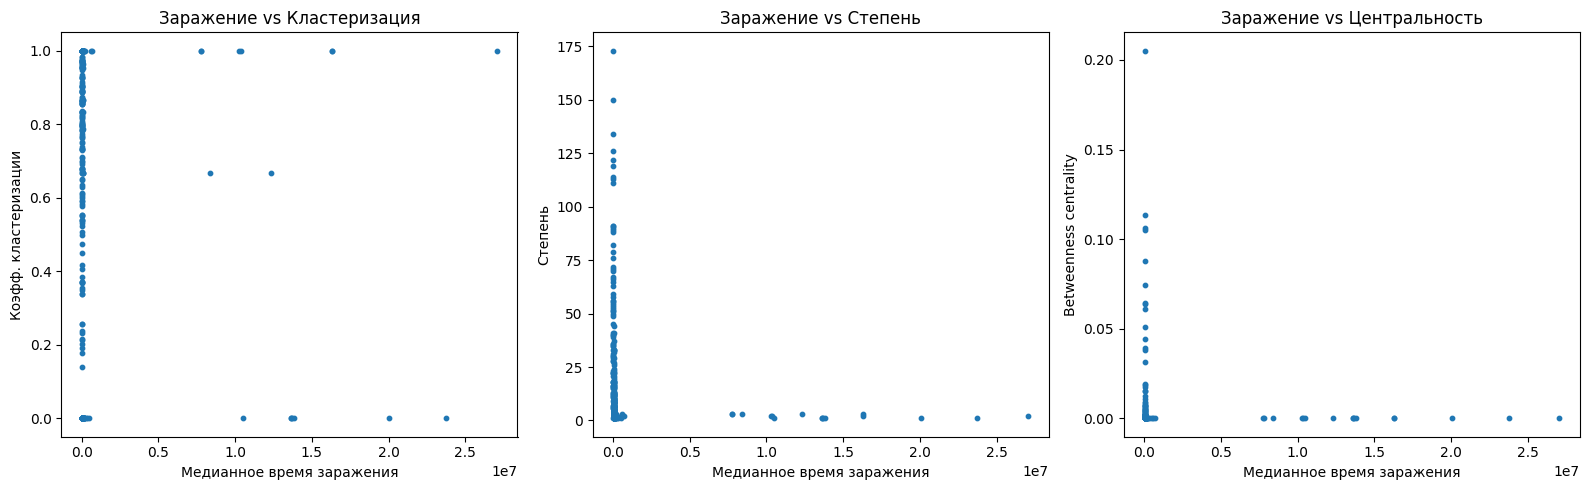

In [32]:
plt.figure(figsize=(16,5))

# 1. Медианное время vs Кластеризация
plt.subplot(1,3,1)
plt.scatter(df_res['median_time'], df_res['clustering'], s=10)
plt.xlabel('Медианное время заражения')
plt.ylabel('Коэфф. кластеризации')
plt.title('Заражение vs Кластеризация')

# 2. Медианное время vs Степень
plt.subplot(1,3,2)
plt.scatter(df_res['median_time'], df_res['degree'], s=10)
plt.xlabel('Медианное время заражения')
plt.ylabel('Степень')
plt.title('Заражение vs Степень')

# 3. Медианное время vs Betweenness centrality
plt.subplot(1,3,3)
plt.scatter(df_res['median_time'], df_res['betweenness'], s=10)
plt.xlabel('Медианное время заражения')
plt.ylabel('Betweenness centrality')
plt.title('Заражение vs Центральность')

plt.tight_layout()
plt.show()

In [33]:
coef_c, pval_c = spearmanr(df_res['median_time'], df_res['clustering'])
coef_d, pval_d = spearmanr(df_res['median_time'], df_res['degree'])
coef_b, pval_b = spearmanr(df_res['median_time'], df_res['betweenness'])

print(f'Кластеризация: корреляция {coef_c:.3f} (p={pval_c:.3g})')
print(f'Степень: корреляция {coef_d:.3f} (p={pval_d:.3g})')
print(f'Betweenness: корреляция {coef_b:.3f} (p={pval_b:.3g})')

Кластеризация: корреляция -0.008 (p=0.892)
Степень: корреляция -0.818 (p=5.16e-74)
Betweenness: корреляция -0.690 (p=6e-44)


**Кластеризация.**

Корреляция: -0.008.\
Никакой значимой статистической зависимости нет.

**Степень (degree).**

Корреляция: -0.818.\
Сильная отрицательная связь. Чем больше степень узла, тем меньше медианное время заражения.\
То есть чем больше соседей, тем быстрее заражение.

**Посредническая центральность (betweenness)**

Корреляция: -0.690.\
Тоже сильная отрицательная связь, но слабее, чем со степенью.
То есть узлы, которые часто оказываются на кратчайших путях между другими узлами, тоже имеют тенденцию иметь меньшее время заражения.